In [1]:
import scanpy as sc
import gzip
import os
import pandas as pd
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import openslide
from tifffile import imwrite
import pickle

from functions import *

In [2]:
# AJER376R
pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs'
pth_ndpi = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/AJER376R_2.ndpi'

# AJGB283
# pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs'
# pth_ndpi = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/AJGB283_2.ndpi'

In [3]:
pth_16um = os.path.join(pth, 'binned_outputs/square_016um')
pth_filtered = os.path.join(pth_16um, 'filtered_feature_bc_matrix')
pth_spatial = os.path.join(pth_16um, 'spatial')

adata = sc.read_visium(pth_16um)
df = make_raw_matrix(pth_16um, adata)

/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


In [ ]:
# # make a downsampled image of the ndpi image
# slide = openslide.OpenSlide(pth_ndpi)
# full_width, full_height = slide.dimensions
# print(f"Full resolution dimensions: {full_width} x {full_height}")
# cropped_region = slide.read_region((0, 0), 0, (full_width, full_height))
# img = cropped_region.convert("RGB")

# ds = 16
# ds_img = np.array(img)[::ds,::ds,:]

# outpth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/downsized_by_16'
# outnm = os.path.join(outpth, os.path.basename(pth_ndpi)[:-5])
# outnm = "".join([outnm, ".tiff"])
# imwrite(outnm, ds_img)

Go to ImageJ, load the image that was just saved and the tissue_hires_image.png from spatial folder
Click points on both using the multipoint button, click like 7-10, focus on Visium location
Plugins -> Transform -> Landmark correspondense
Least Squares, Affine, make sure source image is the high_res image
Make sure to click "show matrix", then copy paste the afffine matrix, it is in a weird format though...

normal aff matrix:
[a b c]
[d e f]
[0 0 1]

output:
[a c e]
[b d f]

376
Matrix: [0.8488036466391021, 4.750750476953311E-4, 1.9998287263397465E-4,
        0.8496312664438789, -626.5688078311568, -2.7420075364470904]

286:
Matrix: [1.05381759957891, -4.972370436692816E-4, 1.2507908498900786E-4,
        1.0519744607876014, -857.7976626084848, 3.556737134836567]

In [4]:
# AJER376R
aff = np.array([[0.8488036466391021, 4.750750476953311E-4, -626.5688078311568],
       [1.9998287263397465E-4, 0.8496312664438789, -2.7420075364470904],
       [0, 0, 1]])


# AJGB283
# aff = np.array([[1.05381759957891, -4.972370436692816E-4,-857.7976626084848],
#                 [1.2507908498900786E-4, 1.0519744607876014, 3.556737134836567],
#                 [0, 0, 1]])

# out_aff = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/H&E stained slides/downsized_by_16/AJGB283_2_aff.pkl'
# with open(out_aff, 'wb') as f:
#     pickle.dump(aff, f)

In [5]:
buffer_size = 4096
ds = 16
adata, npdi_crop_coords = make_full_res_xy(adata, pth_spatial, aff, ds, buffer_size)

ndpi_cropped = read_ndpi(pth_ndpi, npdi_crop_coords)

Full resolution dimensions: 61440 x 44800


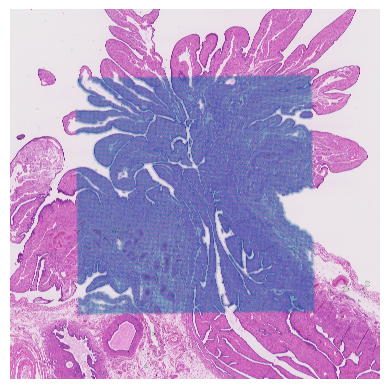

In [6]:
x_offset = npdi_crop_coords[0]
y_offset = npdi_crop_coords[2]

plt.imshow(ndpi_cropped)
plt.scatter(adata.obsm['spatial'][:,0]-x_offset,adata.obsm['spatial'][:,1]-y_offset,s=0.001)
plt.axis('off')
plt.show()

In [7]:
# add a couple pixels to width and height so that when cropping after resizing it looks like above image
pix_ratio = 1 - 0.4536/0.5 # 1 - actual pixel size / desired
print(pix_ratio)
ndpi_cropped_out = read_ndpi_pix_ajd_fix(pth_ndpi, npdi_crop_coords, pix_ratio)

0.0928
Full resolution dimensions: 61440 x 44800


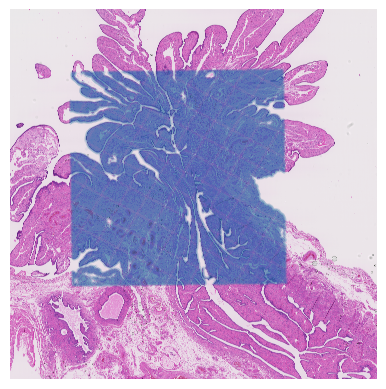

In [8]:
plt.imshow(ndpi_cropped_out)
plt.scatter(adata.obsm['spatial'][:,0]-x_offset,adata.obsm['spatial'][:,1]-y_offset,s=0.001)
plt.axis('off')
plt.show()

In [9]:
outpth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'
outnm = os.path.join(outpth, 'he-raw.png')

ndpi_cropped_out.save(outnm)

In [7]:
spot_names = adata.obs.index.to_list()
tissue_positions_df_processed = pd.DataFrame(index=range(0,len(spot_names)), columns=["Spot","x","y"])

x = adata.obsm['spatial'][:,0]-x_offset
y = adata.obsm['spatial'][:,1]-y_offset

tissue_positions_df_processed['Spot'] = spot_names
tissue_positions_df_processed['x'] = x
tissue_positions_df_processed['y'] = y

tissue_positions_df_processed.head()

Spot             x             y
0  s_016um_00052_00082-1   7112.681641  17093.302734
1  s_016um_00010_00367-1  17132.648438  18447.541016
2  s_016um_00238_00388-1  17766.023438  10430.105469
3  s_016um_00396_00063-1   6291.371094   5018.449219
4  s_016um_00144_00175-1  10334.798828  13822.042969

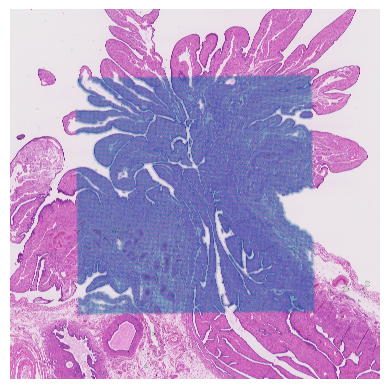

In [8]:
plt.imshow(ndpi_cropped)
plt.scatter(tissue_positions_df_processed['x'],tissue_positions_df_processed['y'],s=0.001)
plt.axis('off')
plt.show()

In [9]:
print(df.shape)
print(tissue_positions_df_processed.shape)

(157222, 18085)
(157222, 3)


QC and variable genes

/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.p

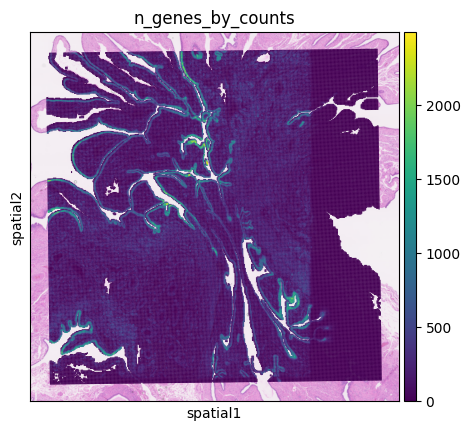

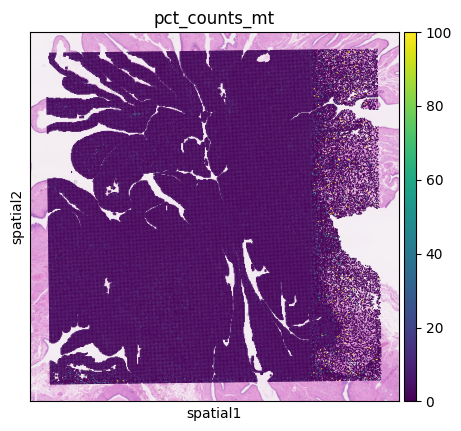

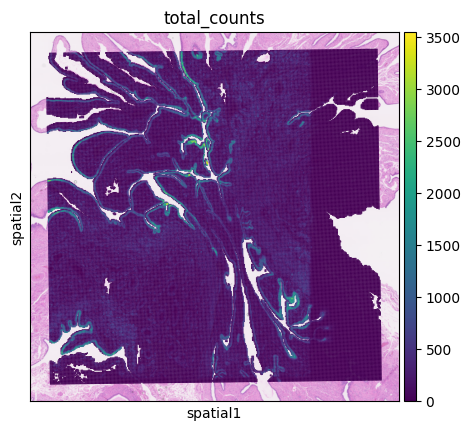

In [10]:
# plots to determine cutoffs for QC
adata_QC = sc.read_visium(pth_16um)
adata_QC = fix_xy(adata_QC)
adata_QC = qc_spots_and_norm(adata_QC, 0, 0, False, False)
sc.pl.spatial(adata_QC, img_key="hires", color="n_genes_by_counts", size=1.5)
sc.pl.spatial(adata_QC, img_key="hires", color="pct_counts_mt", size=1.5)
sc.pl.spatial(adata_QC, img_key="hires", color="total_counts", size=1.5)

/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.p

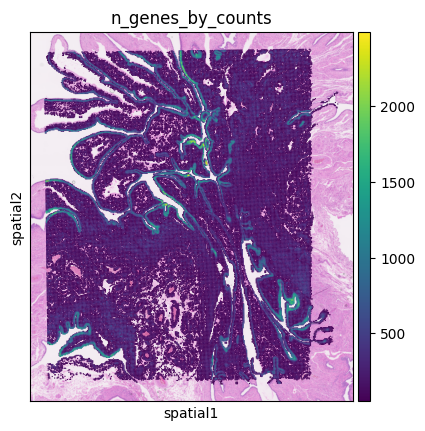

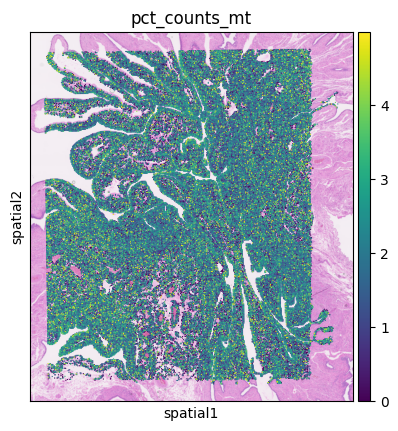

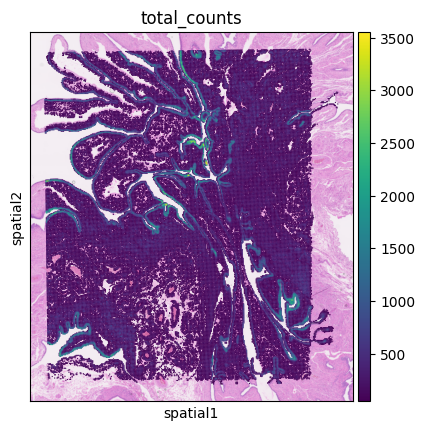

In [11]:
# same as above, but now tweak values for min_genes and filter MT% > 5
min_genes = 50
min_cells = 50
filter_mt = True


adata_QC = sc.read_visium(pth_16um)
adata_QC = fix_xy(adata_QC)
adata_QC = qc_spots_and_norm(adata_QC, min_genes, min_cells, filter_mt, False)
sc.pl.spatial(adata_QC, img_key="hires", color="n_genes_by_counts", size=1.5)
sc.pl.spatial(adata_QC, img_key="hires", color="pct_counts_mt", size=1.5)
sc.pl.spatial(adata_QC, img_key="hires", color="total_counts", size=1.5)

In [13]:

# outpth = '//home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs/binned_outputs/square_016um/AJGB283_training/AJGB283_QC_vars.pkl'
# with open(outpth, 'wb') as f:
#     pickle.dump([min_genes,min_cells,filter_mt], f)

In [12]:
# adjust data based on QC
QCd_spots = adata_QC.obs.index.tolist()
out_pos = tissue_positions_df_processed[tissue_positions_df_processed['Spot'].isin(QCd_spots)]
out_pos.shape

QCd_genes = adata_QC.var.index.tolist()
adata = adata[QCd_spots,adata.var_names.isin(QCd_genes)]

In [13]:
# get highly variable genes in single slide
# I wrote this before the seciton above and forgot I have a parameter for getting highly variable
# genes in that function, but whatever

# read in new variable of adata
adata2 = sc.read_visium(pth_16um)

# subset to spots in tissue
spot_list = adata.obs.index.tolist()
gene_list = adata.var.index.tolist()
adata2 = adata2[spot_list,adata2.var_names.isin(QCd_genes)]

# log data and get highly_variable genes
sc.pp.log1p(adata2)
sc.pp.highly_variable_genes(adata2, n_top_genes=1000)

# save list of highly variable gene names:
gene_names = adata2[:,adata2.var['highly_variable']].var.index.tolist()


/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/readwrite.py:482: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:406: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/donald/miniforge3/envs/visium/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not 

In [16]:
# outpth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs/binned_outputs/square_016um/AJGB283_training/AJGB283_highly_var_genes.pkl'
# with open(outpth, 'wb') as f:
#     pickle.dump(gene_names, f)

Before running this part, run above for each section so that the highly_var pickle file is made for each

In [14]:
# read in both variable genes files and take intersect:
pth_AJER367R_highly_var = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training/AJER376R_highly_var_genes.pkl'
pth_AJGB283_highly_var = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs/binned_outputs/square_016um/AJGB283_training/AJGB283_highly_var_genes.pkl'


with open(pth_AJER367R_highly_var, 'rb') as f:
    AJER367R_highly_var = pickle.load(f)

with open(pth_AJGB283_highly_var, 'rb') as f:
    AJGB283_highly_var = pickle.load(f)

intersect_highly_var = [value for value in AJER367R_highly_var if value in AJGB283_highly_var]

In [15]:
print(len(intersect_highly_var))

532


In [16]:
df.head()

SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  \
s_016um_00052_00082-1     0.0    0.0     0.0      0.0    0.0   0.0    0.0   
s_016um_00010_00367-1     0.0    0.0     0.0      0.0    0.0   0.0    0.0   
s_016um_00238_00388-1     0.0    0.0     0.0      0.0    0.0   0.0    0.0   
s_016um_00396_00063-1     0.0    0.0     0.0      0.0    0.0   0.0    0.0   
s_016um_00144_00175-1     0.0    0.0     0.0      0.0    0.0   0.0    0.0   

                       AGRN  RNF223  C1orf159  ...  MT-ND2  MT-CO2  MT-ATP6  \
s_016um_00052_00082-1   0.0     0.0       0.0  ...     0.0     0.0      0.0   
s_016um_00010_00367-1   0.0     0.0       0.0  ...     0.0     0.0      0.0   
s_016um_00238_00388-1   0.0     0.0       0.0  ...     0.0     0.0      0.0   
s_016um_00396_00063-1   0.0     0.0       0.0  ...     1.0     0.0      1.0   
s_016um_00144_00175-1   0.0     0.0       0.0  ...     0.0     0.0      0.0   

                       MT-CO3  MT-ND3  MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  
s_016um_00052_00082-1     0.0     1.0      0.0     0.0     0.0     0.0     0.0  
s_016um_00010_00367-1     0.0     0.0      0.0     0.0     0.0     0.0     0.0  
s_016um_00238_00388-1     0.0     0.0      0.0     0.0     0.0     0.0     0.0  
s_016um_00396_00063-1     2.0     2.0      1.0     0.0     1.0     2.0     1.0  
s_016um_00144_00175-1     1.0     0.0      1.0     0.0     0.0     0.0     0.0  

[5 rows x 18085 columns]

In [17]:
# subset the df by the columns of intersect_highly_var genes (highly variable genes in both sections)
df_subset = df[intersect_highly_var]

In [18]:
QC_passed_spots = adata.obs.index.to_list()
unprocessed_spots = tissue_positions_df_processed['Spot'].to_list()

processed_spots = np.in1d(unprocessed_spots, QC_passed_spots)
processed_spots = np.array(unprocessed_spots)[processed_spots]

condition = tissue_positions_df_processed['Spot'].isin(processed_spots)

locs_out = tissue_positions_df_processed[condition]
cnts_out = df_subset.loc[QC_passed_spots]

In [19]:
print(locs_out.shape)
print(cnts_out.shape)

(104536, 3)
(104536, 532)


In [82]:
import pandas as pd
cnts_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs/binned_outputs/square_016um/AJGB283_training/cnts.tsv'
locs_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs/binned_outputs/square_016um/AJGB283_training/locs-raw.tsv'

cnts_out = pd.read_csv(cnts_pth,sep='\t',)
locs_out = pd.read_csv(locs_pth,sep='\t')

Image.MAX_IMAGE_PIXELS = None
he_im = Image.open('/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJGB283/outs/binned_outputs/square_016um/AJGB283_training/he-raw.png')
he_im = np.array(he_im)

In [75]:
# import pandas as pd
# cnts_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training/cnts.tsv'
# locs_pth = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training/locs-raw.tsv'

# cnts_out = pd.read_csv(cnts_pth,sep='\t',)
# locs_out = pd.read_csv(locs_pth,sep='\t')

# Image.MAX_IMAGE_PIXELS = None
# he_im = Image.open('/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training/he-raw.png')
# he_im = np.array(he_im)

In [83]:
width, height = he_im.shape[:2]

scale = 0.4516/0.5
new_width = int(width * scale)
new_height = int(height * scale)

he_im = he_im[:new_width,:new_height,:]

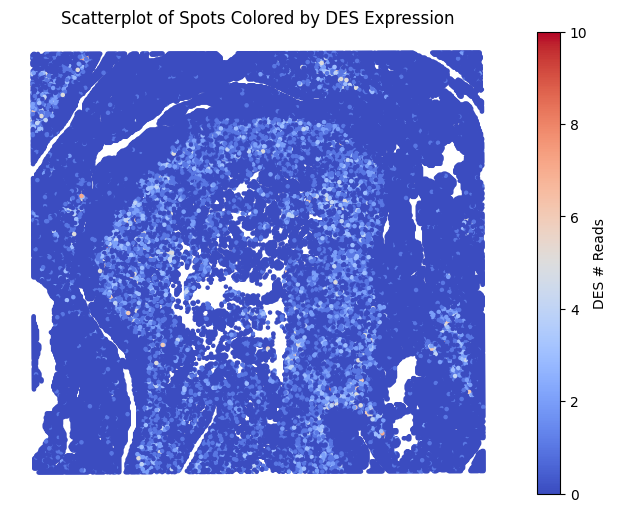

In [84]:
# visually inspect an epithelial gene
gene = 'DES'
gene_exp = cnts_out[gene]
spot_coords = np.array(locs_out[['x','y']])

# Create scatterplot
plt.figure(figsize=(8,6))
scatter = plt.scatter(spot_coords[:, 0], spot_coords[:, 1], c=gene_exp, cmap='coolwarm', s=5)

# Add colorbar
plt.colorbar(scatter, label=f"{gene} # Reads")

# Add labels and titleW
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Scatterplot of Spots Colored by {gene} Expression')
plt.axis('off')

plt.show()

In [85]:
width = max(spot_coords[:, 0]) - min(spot_coords[:, 0])

pth_scale_factors = os.path.join(pth_spatial, 'scalefactors_json.json')
with open(pth_scale_factors, 'rb') as f:
    scale_factors = json.load(f)

print(width)

bin_size_um = scale_factors['bin_size_um']
um_per_pix = 0.4516

scale = bin_size_um/um_per_pix

print(width/scale)

n_hex = int(width/scale)
print(n_hex/4)

# hexbin gridsize for 64 micron bins
n_hex_um64_bin = int(n_hex/4)

14730.117300000002
415.75756079250004
103.75


In [ ]:
# Define the gene and extract its expression values
gene = 'DES'
gene_exp = cnts_out[gene]
spot_coords = np.array(locs_out[['x', 'y']])

plt.figure(figsize=(8, 6))
plt.imshow(he_im)

# Create hexbin heatmap
heatmap = plt.hexbin(spot_coords[:, 0], spot_coords[:, 1], C=gene_exp, gridsize=n_hex_um64_bin, cmap='coolwarm')

# Add colorbar to indicate gene expression levels
plt.colorbar(heatmap, label=f"{gene} # Reads")

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
#plt.title(f'64 um binned Visium HD {gene} Expression')

# Remove axis for a cleaner look
plt.axis('off')
#plt.gca().invert_yaxis()

plt.show()

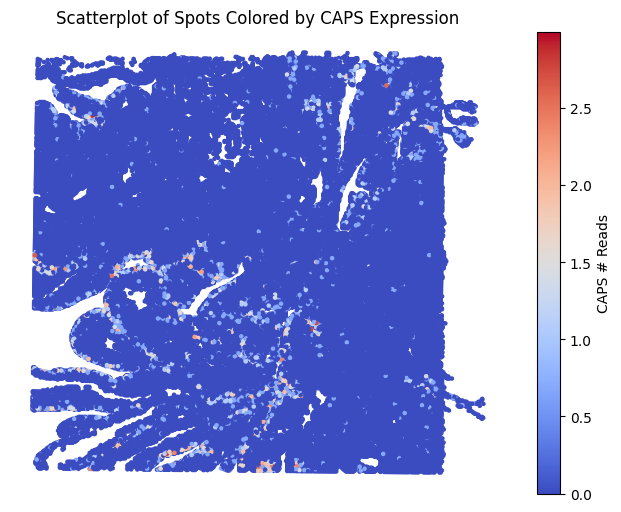

In [21]:
# visually inspect an epithelial gene
gene = 'CAPS'

adata2 = fix_xy(adata2)

gene_id = adata2.var['gene_ids'].index.tolist().index(gene)
gene_exp = adata2.X.toarray()[:,gene_id]
spot_coords = adata2.obsm['spatial']

# Create scatterplot
plt.figure(figsize=(8,6))
scatter = plt.scatter(spot_coords[:, 0], spot_coords[:, 1], c=gene_exp, cmap='coolwarm', s=5)

# Add colorbar
plt.colorbar(scatter, label=f"{gene} # Reads")

# Add labels and titleW
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Scatterplot of Spots Colored by {gene} Expression')
plt.axis('off')

plt.show()

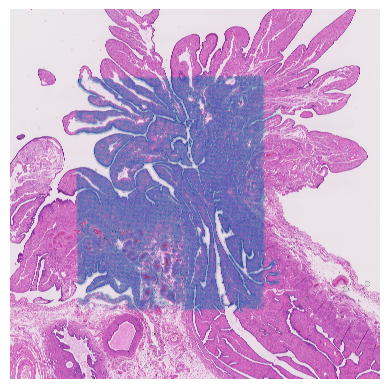

In [22]:
plt.imshow(ndpi_cropped)
plt.scatter(locs_out['x'],locs_out['y'],s=0.001)
plt.axis('off')
plt.show()

In [23]:
# out_folder = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'

# outpth = os.path.join(out_folder, "locs-raw.tsv")
# locs_out.to_csv(outpth, sep='\t')

In [24]:
# out_folder = '/home/donald/Desktop/Andre_expansion/data/CODA Fallopian tube/visium hd/LK01JHU510_000_analysis/count/AJER376R/outs/binned_outputs/square_016um/donald_analysis/AJER376R_training'

# outpth = os.path.join(out_folder, "cnts.tsv")
# cnts_out.to_csv(outpth, sep='\t')